/var/folders/24/8pzn85m10vqgk7r1c979brn00000gn/T/ipykernel_93018/386981986.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


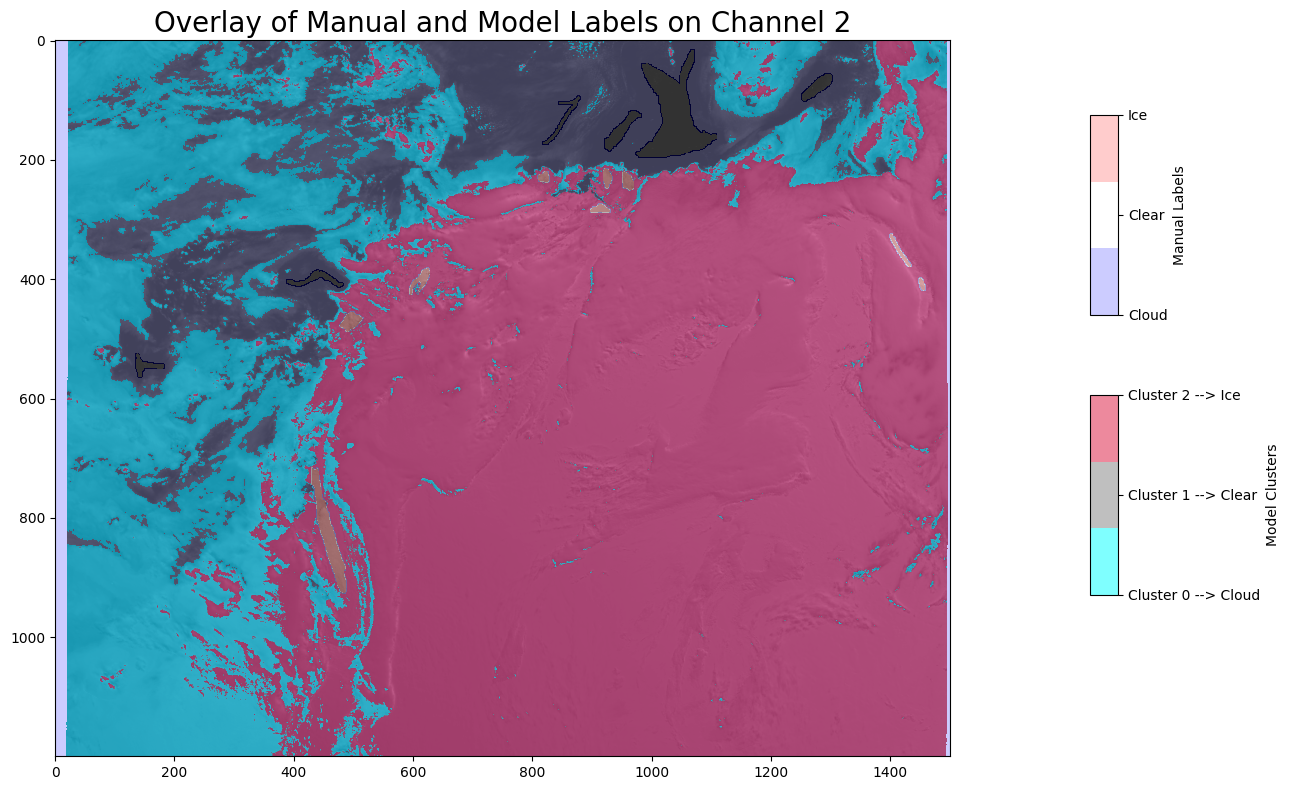

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Load datasets
def load_and_concat_datasets(parent_folder, filenames):
    datasets = [xr.open_dataset(f'{parent_folder}/{filename}')[filename.split('.')[0]] for filename in filenames]
    combined = xr.concat(datasets, dim='band')
    return combined

# Combine manual labels
def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape, dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

# Compute model labels using gmm
def compute_model_labels_with_gmm(ds_combined, channel_idx):
    data_channel = ds_combined[channel_idx].values
    data_flat = data_channel.flatten()
    nan_mask = np.isnan(data_flat)
    data_clean = data_flat[~nan_mask]

    gmm = GaussianMixture(n_components=3).fit(data_clean.reshape(-1, 1))
    model_labels = np.full(data_flat.shape, np.nan)
    model_labels[~nan_mask] = gmm.predict(data_clean.reshape(-1, 1))

    return model_labels.reshape(data_channel.shape)

# Overlay and plot model labels on top of manual labels
def plot_overlay(channel_data, model_labels, manual_labels, channel_num):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Discrete colours for labels
    colors_manual = ['blue', 'white', 'red']
    colors_model = ['cyan', 'gray', 'crimson']
    
    cmap_manual = ListedColormap(colors_manual)
    cmap_model = ListedColormap(colors_model)
    
    ax.imshow(channel_data, cmap='gray')
    
    # Show manual labels
    im_manual = ax.imshow(manual_labels, cmap=cmap_manual, alpha=0.2, vmin=0, vmax=2)

    # Show model labels using a mask to hide model labels where manual labels are present
    im_model = ax.imshow(np.ma.masked_where(manual_labels != 0, model_labels), cmap=cmap_model, alpha=0.5, vmin=0, vmax=2)
    
    # Colourbar for manual labels
    cax1 = fig.add_axes([0.92, 0.6, 0.02, 0.25])
    cbar_manual = fig.colorbar(im_manual, cax=cax1, ticks=[0, 1, 2])
    cbar_manual.set_label('Manual Labels')
    cbar_manual.ax.set_yticklabels(['Cloud', 'Clear', 'Ice'])
    
    # Colourbar for model labels
    cax2 = fig.add_axes([0.92, 0.25, 0.02, 0.25])
    cbar_model = fig.colorbar(im_model, cax=cax2, ticks=[0, 1, 2])
    cbar_model.set_label('Model Clusters')
    cbar_model.ax.set_yticklabels(['Cluster 0 --> Cloud', 'Cluster 1 --> Clear', 'Cluster 2 --> Ice'])
    
    ax.set_title(f'Overlay of Manual and Model Labels on Channel {channel_num}', y=1, fontsize=20)
    plt.tight_layout()
    plt.show()


# Paths
parent_folder = '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel5/'
channels = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 
            'S5_radiance_in.nc', 'S6_radiance_in.nc', 'S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']

# Loading datasets
ds_combined = load_and_concat_datasets(parent_folder, channels)

# Choose a channel to display
chosen_channel_idx = 1
channel_data = ds_combined[chosen_channel_idx].values

# Compute model labels
model_labels_gmm = compute_model_labels_with_gmm(ds_combined, chosen_channel_idx)

# Loading manual labels and combining
cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']
manual_labels = get_combined_labels(cloud_labels, clear_labels, ice_labels)

# Plot overlay
channel_number = chosen_channel_idx + 1
plot_overlay(channel_data, model_labels_gmm, manual_labels, channel_number)
